In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from collections import deque, namedtuple

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

In [2]:
from gym.wrappers.record_video import RecordVideo

In [3]:
SEED = 42

In [4]:
class DQN(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()

    self.fc1 = nn.Linear(in_features=inputs, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=64)
    self.fc4 = nn.Linear(in_features=64, out_features=32)
    self.out = nn.Linear(in_features=32, out_features=outputs)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.out(x)
    return x

In [5]:
Experience = namedtuple("Experience", field_names=[
                        "state", "action", "reward", "next_state", "done"])


class ReplayMemory(object):
  """
  Class adapted from PyTorch example:
  https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
  """

  def __init__(self, buffer_size, batch_size, seed):
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.seed = random.seed(seed)

  def push(self, state, action, reward, next_state, done):
    self.memory.append(Experience(state, action, reward, next_state, done))

  def sample(self, device):
    """ 
    Sample a set memories.
    Code adapted from a post from Chanseok Kang:
    https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
    """
    experiences = random.sample(self.memory, k=self.batch_size)
    '''
    states = torch.from_numpy(
        np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(
        np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(
        np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack(
        [e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack(
        [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    '''
    states, actions, rewards, next_states, dones = zip(*experiences)
    result = []
    for state in states:
        if isinstance(state, np.ndarray):
            result.append(state)
        elif isinstance(state, tuple) and isinstance(state[0], np.ndarray):
            result.append(state[0])
    states = tuple(result)
    states = torch.tensor(np.array(states), dtype=torch.float32, device=device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)
    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)

In [6]:
'''
class SimpleDQNAgent():
  def __init__(
      self,
      state_vector_length,
      num_actions,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.num_actions = num_actions
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)

    self.memory = ReplayMemory(100000, batch_size, seed)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = np.random.randint(0, self.num_actions)
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    with torch.no_grad():
      action = self.policy_net(torch.tensor([s]).to(
          self.device)).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, s_prime, r, done):
    self.memory.push(s, a, r, s_prime, done)
    self.step += 1

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    next_q_values = self.policy_net(
        next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    #loss = F.mse_loss(current_q_values, q_targets)
    loss = F.smooth_l1_loss(current_q_values, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def save_network(self, outfile):
    torch.save(self.policy_net.state_dict(), outfile)

  def load_network(self, infile):
    self.policy_net.load_state_dict(torch.load(infile))
    self.policy_net.eval()
'''

'\nclass SimpleDQNAgent():\n  def __init__(\n      self,\n      state_vector_length,\n      num_actions,\n      alpha=.001,\n      eps=1,\n      eps_decay=0.995,\n      eps_min=0.05,\n      gamma=0.9,\n      batch_size=64,\n      seed=None\n  ):\n    self.num_actions = num_actions\n    self.eps = eps\n    self.eps_decay = eps_decay\n    self.eps_min = eps_min\n    self.gamma = gamma\n    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n    self.step = 0\n    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)\n    self.optimizer = torch.optim.Adam(\n        params=self.policy_net.parameters(), lr=alpha)\n\n    self.memory = ReplayMemory(100000, batch_size, seed)\n\n    if seed != None:\n      np.random.seed(seed)\n\n  def select_action(self, s):\n    self.step += 1\n    if np.random.random() < self.eps:\n      action = np.random.randint(0, self.num_actions)\n    else:\n      action = self._get_best_action(s)\n\n    return action\n\n  def

In [23]:

class DQNAgent():
  def __init__(
      self,
      state_vector_length,
      num_actions,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.num_actions = num_actions
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)

    self.memory = ReplayMemory(100000, batch_size, seed)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = np.random.randint(0, self.num_actions)
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    #print("Type(s) : ", type(s))
    #print("s : ", s)
    if isinstance(s, tuple) and isinstance(s[0], np.ndarray):
        s = s[0]
    with torch.no_grad():
      action = self.policy_net(torch.tensor([s]).to(
          self.device)).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, s_prime, r, done):
    self.memory.push(s, a, r, s_prime, done)
    self.step += 1

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    next_q_values = self.target_net(
        next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    loss = F.mse_loss(current_q_values, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def save_network(self, outfile):
    torch.save(self.policy_net.state_dict(), outfile)

  def load_network(self, infile):
    self.policy_net.load_state_dict(torch.load(infile))
    self.policy_net.eval()


In [24]:
class DDQNAgent():
  def __init__(
      self,
      state_vector_length,
      num_actions,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.num_actions = num_actions
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)

    self.memory = ReplayMemory(100000, batch_size, seed)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = np.random.randint(0, self.num_actions)
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    #print("Type(s) : ", type(s))
    #print("s : ", s)
    if isinstance(s, tuple) and isinstance(s[0], np.ndarray):
        s = s[0]
    with torch.no_grad():
      action = self.policy_net(torch.tensor([s]).to(
          self.device)).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, s_prime, r, done):
    self.memory.push(s, a, r, s_prime, done)
    self.step += 1

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences
    next_actions = self.policy_net(next_states).detach().max(1)[-1].unsqueeze(1)
    next_q_values = self.target_net(next_states).gather(1, next_actions)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    loss = F.mse_loss(current_q_values, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def save_network(self, outfile):
    torch.save(self.policy_net.state_dict(), outfile)

  def load_network(self, infile):
    self.policy_net.load_state_dict(torch.load(infile))
    self.policy_net.eval()

In [25]:
def moving_average(data, window):
  series = pd.Series(data)
  return series.rolling(window).mean()
'''
def plot_rewards(values):
  plt.figure(2)
  plt.clf()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(values)
  plt.plot(moving_average(values, 100))
'''    
def plot_rewards(values):
  score = np.array(values)
  avg_score = moving_average(values, 100)
  plt.figure(figsize=(15,7))
  plt.clf()
  plt.ylabel("Trajectory Duration",fontsize=12)
  plt.xlabel("Episodes",fontsize=12)
  plt.plot(score, color='gray' , linewidth=1)
  plt.plot(avg_score, color='blue', linewidth=3)
  plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)


def plot_multiple_rewards(variable, rewards_dict):
  plt.figure(2)
  plt.clf()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  for key, rewards in rewards_dict.items():
    plt.plot(rewards, label=f'{variable} = {key}')
  plt.legend()

In [26]:
def lander_runner(num_episodes, target_update, alpha, eps, eps_decay, gamma, seed, convergence_threshold=200, render=False):
  env = gym.make('LunarLander-v2')
  #env.seed(SEED)
  agent = DDQNAgent(env.observation_space.shape[0], env.action_space.n,
                   alpha=alpha, eps=eps, eps_decay=eps_decay, gamma=gamma, seed=seed)
  rewards = []

  for e in range(num_episodes):
    cur_observation = env.reset(seed=seed)
    if render:
      env.render()
    episode_reward = 0
    for t in count():
      action = agent.select_action(cur_observation)
      next_observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      agent.update_q(cur_observation, action, next_observation, reward, done)
      cur_observation = next_observation
      episode_reward += reward
      if render:
        env.render()
      if done:
        rewards.append(episode_reward)
        plot_rewards(rewards)
        plt.pause(0.01)
        print(f'Episode {e}: {episode_reward}')
        if is_ipython:
          display.clear_output(wait=True)
        break
    if e % target_update == 0:
      agent.update_target()
    '''
    if np.all(moving_average(rewards, 100)[-100:] >= convergence_threshold):
      print(f'Solved in {e} episodes.')
      #agent.save_network(f'out\\agent.pt')
      break
    '''
  env.close()
  return rewards, agent

In [12]:
#type(agent)

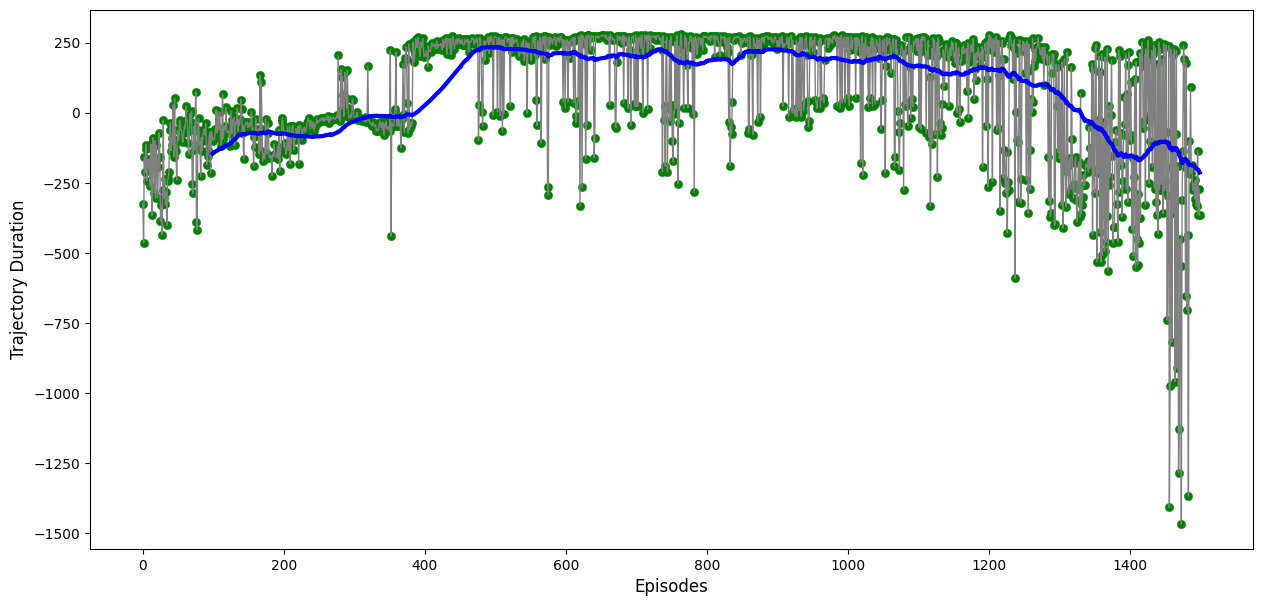

In [27]:
run_rewards, agent = lander_runner(
    num_episodes=1500,
    target_update=4,
    alpha=0.0005,
    eps=1,
    eps_decay=0.99,
    gamma=0.999,
    seed=42,
    convergence_threshold=300
)

plot_rewards(run_rewards)
plt.savefig('out\\learning_curve.png')

In [14]:
sum(run_rewards)/len(run_rewards)

111.26595904782279

In [15]:
agent.save_network(f'out\\DQN_agent_seed_42_ep1500_g975.pt')

In [16]:
from gym.wrappers import RecordVideo

In [17]:
def load_model(model_path, state_vector_length, num_actions):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DQN(state_vector_length, num_actions).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load your model (ensure the state_vector_length and num_actions are set correctly)
model_path = 'out\\agent_seed_42_ep1500.pt'
env = gym.make('LunarLander-v2')
model = load_model(model_path, env.observation_space.shape[0], env.action_space.n)

In [18]:
def choose_action(s, model, device):
    if isinstance(s, tuple) and isinstance(s[0], np.ndarray):
        s = s[0]
    with torch.no_grad():
      action = model(torch.tensor([s]).to(device)).argmax(dim=1).to(device).item()
    return action

In [19]:
def run_episode(env, model):
    state = env.reset()
    done = False
    while not done:
        action = choose_action(state, model, "cuda")
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        env.render()
    env.close()

In [21]:

tmp_env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="out\\recording", name_prefix="DQN_agent_seed_42_ep1500_g975", episode_trigger=lambda x: x % 2 == 0)
# Start the recorder
observation, info = env.reset()
env.start_video_recorder()
# Run the environment and record the video
run_episode(env, model)
env.close_video_recorder()

# Close the environment
env.close()


Moviepy - Building video C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4.
Moviepy - Writing video C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4


Moviepy - Building video C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4.
Moviepy - Writing video C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\giris\OneDrive\Documents\Bath Computer Science\Semester 2\Reinforcement Learning\Practice\out\recording\DQN_agent_seed_42_ep1500_g975-episode-0.mp4
